# Shuttlt bus data analysis

### note: not calculate distance and predict by original data 

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
import plotly
from datetime import tzinfo, timedelta, datetime

### load file

In [3]:
#get the stop segment
csv_stop = pd.read_csv("./../data/iot.stops.csv",sep = '\t',header = 0)
csv_route = pd.read_csv("./../data/iot.routes.csv",sep = '\t',header = 0)

#for calculate the distances between 2 stops 
csv_record = pd.read_csv("./../data/iot.locations.csv",sep = '\t',header = 0)

In [80]:
csv_stop.head(2)

,_id,isGoToWork,latitude,longitude,stopName,updated
0,5ae83320748fb2a67c5f6e54,True,22.249541,113.520559,明珠中,2018-05-01T09:28:00.844Z
1,5ae8334c748fb2a67c5f6e55,True,22.256653,113.519771,翠微,2018-05-01T09:28:44.366Z


In [81]:
csv_route.head(2)

,_id,busId,isGo2Work,plannedArrivalTime,routeNumber,seqNumber,stopId,updated
0,5ae83df03023169da447c2b6,5ae8393c3023169da447c2ae,True,7:38,1,5,5ae83521567e17937cf407e2,2018-05-01T10:14:08.961Z
1,5ae83e6c3023169da447c2b9,5ae8399c3023169da447c2af,True,7:33,2,2,5ae83590567e17937cf407e5,2018-05-01T10:16:12.721Z


In [82]:
csv_record.head(2)

,bus,device,latitude,longitude,updated
0,1,stm32,22.251497,113.517815,2018-05-20T10:43:01.277Z
1,1,stm32,22.251497,113.517807,2018-05-20T10:43:17.674Z


## 1. data display

### @functions

In [38]:
#坐标系转平面坐标
def mct2x(lat):
    x = lat/ 20037508.3427892 * 180 
    return x
def mct2y(lon):
    result = []
    for i in lon:
        y = i/ 20037508.3427892 * 180 
        y = 180 / math.pi * (2 * math.atan(math.exp(y * math.pi / 180)) - math.pi / 2) 
        result.append(y)
    return result

# record should order by longitude first
def core_field_extra(stops,records):
    start = datetime.now()
    
    df =pd.DataFrame(columns = ['latitude','longitude','routeNumber','last_stop_name','last_stop_seq',
                                'next_stop_name','next_stop_seq','last_stop_latitude','last_stop_longitude',
                                'next_stop_latitude','next_stop_longitude','segment','updated','plannedArrivalTime',
                                'plannedTimeSpan','device','ATE'])
    latitude = '' 
    longitude = ''
    routeNumber = route_stops.iloc[0].routeNumber 
    updated = ''
    plannedArrivalTime = ''
    last_stop_name = ''
    last_stop_seq = ''
    next_stop_name = ''
    next_stop_seq = ''
    last_stop_latitude = ''
    last_stop_longitude = ''
    next_stop_latitude = ''
    next_stop_longitude = ''
    device = ''
    ate = ''
    
    bus_tracker = 0 #// for bus stop change use
 
    for raw in records.itertuples():
        if(bus_tracker < len(stops)):
            flag = raw.latitude < stops.iloc[[bus_tracker]].latitude
            if(flag.any()):
#                     print(raw)
                    continue
            elif(bus_tracker+1 < len(stops)):
                if((raw.latitude >= stops.iloc[[bus_tracker]].latitude).any() & (raw.latitude <= stops.iloc[[bus_tracker+1]].latitude).any()):
                    latitude = raw.latitude
                    longitude = raw.longitude
                    updated = raw.updated
                    plannedArrivalTime = stops.iloc[bus_tracker+1].plannedArrivalTime
                    device = raw.device
                    last_stop_name = stops.iloc[bus_tracker].stopName
                    last_stop_seq = stops.iloc[bus_tracker].seqNumber
                    next_stop_name = stops.iloc[bus_tracker + 1].stopName
                    next_stop_seq = stops.iloc[bus_tracker + 1].seqNumber
                    last_stop_latitude = stops.iloc[bus_tracker].latitude
                    last_stop_longitude = stops.iloc[bus_tracker].longitude
                    next_stop_latitude = stops.iloc[bus_tracker + 1].latitude
                    next_stop_longitude = stops.iloc[bus_tracker + 1].longitude
                    segment = stops.iloc[bus_tracker,10] + '-' + stops.iloc[bus_tracker+1,10]
                    ate = 'N/A'
                    plannedTimeSpan = (pd.to_datetime(stops.iloc[bus_tracker + 1].plannedArrivalTime) - pd.to_datetime(stops.iloc[bus_tracker].plannedArrivalTime)).total_seconds()
                    df = df.append({'latitude':latitude,'longitude':longitude,'routeNumber':routeNumber,
                                    'last_stop_name':last_stop_name,'last_stop_seq':last_stop_seq,
                                    'next_stop_name':next_stop_name,'next_stop_seq':next_stop_seq,
                                    'last_stop_latitude':last_stop_latitude,'last_stop_longitude':last_stop_longitude,
                                    'next_stop_latitude':next_stop_latitude,'next_stop_longitude':next_stop_longitude,
                                    'segment':segment,'updated':updated,'plannedArrivalTime':plannedArrivalTime,
                                    'plannedTimeSpan':plannedTimeSpan,'device':device,'ATE':ate},ignore_index=True)
                else:
                    latitude = '' 
                    longitude = ''
                    updated = ''
                    plannedArrivalTime = ''
                    device = ''
                    last_stop_name = ''
                    last_stop_seq = ''
                    next_stop_name = ''
                    next_stop_seq = ''
                    last_stop_latitude = ''
                    last_stop_longitude = ''
                    next_stop_latitude = ''
                    next_stop_longitude = ''
                    
                    df.loc[df.ATE == 'N/A', 'ATE'] = raw.updated
                    bus_tracker= bus_tracker + 1 

#         print('sub_main_Duration:',(datetime.now() - start).total_seconds())
#     print('sub_Duration:',(datetime.now() - start).total_seconds())
    if(len(records) > 0):
        df.loc[df.ATE == 'N/A', 'ATE'] = records.iloc[-1].updated
    return df
        
def calculate_distance(lat1,lng1,lat2,lng2):
    radlat1= math.radians(lat1)  
    radlat2=math.radians(lat2)  
    a=radlat1-radlat2  
    b=math.radians(lng1)-math.radians(lng2)  
    s=2*math.asin(math.sqrt(math.pow(math.sin(a/2),2)+math.cos(radlat1)*math.cos(radlat2)*math.pow(math.sin(b/2),2)))  
    earth_radius = 6371.393  
    s=s*earth_radius  
    if(s<0):
        return -s*1000
    else:
        return s*1000
 

In [39]:
# link route and stop info together
csv_route_num1 = csv_route[(csv_route.routeNumber ==1) & (csv_route.isGo2Work == True) ]
csv_route_num1 = csv_route_num1.sort_values(["seqNumber"],ascending = True)
csv_route_num1 = csv_route_num1.iloc[:,1:7]

route_stops = csv_route_num1.merge(csv_stop,left_on='stopId',right_on = '_id')

In [40]:
route_stops.head(100)

,busId,isGo2Work,plannedArrivalTime,routeNumber,seqNumber,stopId,_id,isGoToWork,latitude,longitude,stopName,updated
0,5ae8393c3023169da447c2ae,True,7:23,1,1,5ae83320748fb2a67c5f6e54,5ae83320748fb2a67c5f6e54,True,22.249541,113.520559,明珠中,2018-05-01T09:28:00.844Z
1,5ae8393c3023169da447c2ae,True,7:26,1,2,5ae8334c748fb2a67c5f6e55,5ae8334c748fb2a67c5f6e55,True,22.256653,113.519771,翠微,2018-05-01T09:28:44.366Z
2,5ae8393c3023169da447c2ae,True,7:34,1,3,5ae8336c748fb2a67c5f6e56,5ae8336c748fb2a67c5f6e56,True,22.267762,113.536134,仁恒星园,2018-05-01T09:29:16.147Z
3,5ae8393c3023169da447c2ae,True,7:37,1,4,5ae834df567e17937cf407e1,5ae834df567e17937cf407e1,True,22.268722,113.542062,香洲区府,2018-05-01T09:35:27.388Z
4,5ae8393c3023169da447c2ae,True,7:38,1,5,5ae83521567e17937cf407e2,5ae83521567e17937cf407e2,True,22.269261,113.545517,南村,2018-05-01T09:36:33.812Z
5,5ae8393c3023169da447c2ae,True,7:40,1,6,5ae8353d567e17937cf407e3,5ae8353d567e17937cf407e3,True,22.276603,113.557696,兴业中,2018-05-01T09:37:01.373Z
6,5ae8393c3023169da447c2ae,True,8:30,1,7,5af85642ac5680781c7bb90c,5af85642ac5680781c7bb90c,True,22.372631,113.575924,南方软件园,2018-05-13T15:14:10.382Z


In [7]:
route_stops.iloc[0].seqNumber

1

In [41]:
#filter 2018-5-30 
csv_record_bus1 = csv_record[(csv_record['bus']== 1.0)
                              & (csv_record['device']!= 'arduino')
                              & (pd.to_datetime(csv_record['updated'],utc = True) > pd.to_datetime('2018/05/29 23:00',utc = True))
                              & (pd.to_datetime(csv_record['updated'],utc = True) < pd.to_datetime('2018/05/30 00:40',utc = True))] # filter all bus1 data

In [42]:
csv_record_bus1 = csv_record_bus1.sort_values(by = 'updated',ascending = True)
bus1_copy = csv_record_bus1.copy()
location = bus1_copy

location.head()

,bus,device,latitude,longitude,updated
3134,1,stm32,22.249014,113.520707,2018-05-29T23:21:43.842Z
3135,1,stm32,22.249225,113.520638,2018-05-29T23:22:14.549Z
3136,1,stm32,22.249286,113.520600,2018-05-29T23:22:31.428Z
3137,1,stm32,22.249292,113.520736,2018-05-29T23:22:47.368Z
3138,1,stm32,22.249290,113.520820,2018-05-29T23:23:03.585Z


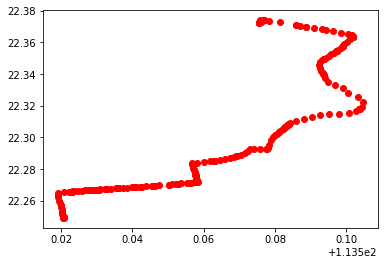

In [43]:
plt.plot(location['longitude'],location['latitude'],'ro')

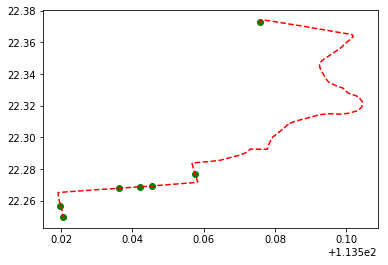

In [44]:
plt.plot(route_stops.longitude,route_stops.latitude, "go",location['longitude'],location['latitude'],'r--')

## 2.data extra

### @functions

In [45]:
# start_date: date time start, string format: yyyy/MM/dd HH:mm, kindly remind start HH:mm should be '23:00'
# stop_date: date time ending, string format: yyyy/MM/dd HH:mm, kindly remind stop HH:mm should be '00:40'
# records

def extra_train_test_data(start_date,stop_date,records,stops):
    # caluculate the time span of all data by day, and arrange the data  
    start = datetime.now()
    time_span = pd.to_datetime(stop_date,utc = True) - pd.to_datetime(start_date,utc = True)
    time_span = time_span.days +1


    final_df = pd.DataFrame(columns = ['latitude','longitude','routeNumber','last_stop_name','last_stop_seq',
                                'next_stop_name','next_stop_seq','last_stop_latitude','last_stop_longitude',
                                'next_stop_latitude','next_stop_longitude','segment','updated','plannedArrivalTime',
                                'plannedTimeSpan','device','ATE'])
    for i in range(time_span):
        current_start_date = pd.to_datetime(start_date,utc = True) + timedelta(days = i)
        current_stop_date = current_start_date + timedelta(hours = 1, minutes = 40)
        
#         print('current_start_date: ' + str(current_start_date))
#         print('current_stop_date' + str(current_stop_date))
        current_record_busi_all = records[(pd.to_datetime(records['updated'],utc = True) > pd.to_datetime(current_start_date,utc = True))
                              & (pd.to_datetime(records['updated'],utc = True) < pd.to_datetime(current_stop_date,utc = True))] 
        current_location = current_record_busi_all
#         print('total location: ' + str(current_location.shape))
#         print('main_sub_Duration:',(datetime.now() - start).total_seconds())
        current_extra = core_field_extra(stops,current_location)
        final_df = final_df.append(current_extra, ignore_index=True)
    
        
     # save the result to csv
    final_df.to_csv('./../data/pure_data/pure_data1.csv',sep = '|',encoding = 'utf-8') 

    print('----------------------------------')
    print('all data start date: ' + str(pd.to_datetime(csv_record_bus1_all.iloc[0].updated,utc = True)))
    print('all data ending date: ' + str(pd.to_datetime(csv_record_bus1_all.iloc[-1].updated,utc = True)))
    print('time span(/day): ' + str(time_span))
    print('Duration:',(datetime.now() - start).total_seconds())
    print('----------------------------------')
    
    return final_df

### A.sample for test

In [46]:
#show 5.30 data extra result
_5_30 = core_field_extra(route_stops,location)
sh = _5_30[_5_30.ATE == 'N/A']
_5_30.tail(100)

,latitude,longitude,routeNumber,last_stop_name,last_stop_seq,next_stop_name,next_stop_seq,last_stop_latitude,last_stop_longitude,next_stop_latitude,next_stop_longitude,segment,updated,plannedArrivalTime,plannedTimeSpan,device,ATE
133,22.288242,113.569453,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-29T23:59:33.036Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z
134,22.288891,113.570412,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-29T23:59:47.094Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z
135,22.289899,113.571555,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-30T00:00:01.176Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z
136,22.291144,113.572468,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-30T00:00:15.295Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z
137,22.292515,113.573085,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-30T00:00:31.384Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z
138,22.292451,113.574023,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-30T00:00:45.437Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z
139,22.292368,113.575713,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-30T00:00:59.576Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z
140,22.292365,113.577542,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-30T00:01:13.679Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z
141,22.292385,113.577876,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-30T00:01:27.720Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z
142,22.292978,113.577945,1,兴业中,6,南方软件园,7,22.276603,113.557696,22.372631,113.575924,兴业中-南方软件园,2018-05-30T00:01:42.033Z,8:30,3000.0,stm32,2018-05-30T00:26:14.104Z


In [ ]:
# train_data_set.to_csv('./../data/pure_data/_5_30.csv',sep = '|',encoding = 'utf-8')  # save the result to csv

### B.extra all history records

In [47]:
# filter all stm32 data from 5,22 to 5,30
csv_record_bus1_all = csv_record[(csv_record['bus']== 1.0)
                              & (csv_record['device']!= 'arduino')
                              & (pd.to_datetime(csv_record['updated'],utc = True) > pd.to_datetime('2018/05/21 23:00',utc = True))
                              & (pd.to_datetime(csv_record['updated'],utc = True) < pd.to_datetime('2018/06/26 00:40',utc = True))] # filter all bus1 data


In [48]:
csv_record_bus1_all = csv_record_bus1_all.sort_values(by = 'updated',ascending = True)
csv_record_bus1_all.shape

(45743, 5)

In [49]:
# # caluculate the time span of all data by day, and arrange the data  
# time_span = pd.to_datetime(csv_record_bus1_all.iloc[-1].updated,utc = True) - pd.to_datetime(csv_record_bus1_all.iloc[0].updated,utc = True)
# time_span = time_span.days +1


# final_df = pd.DataFrame(columns = ['segment','distance(unit: m)','frequency','span(unit: s)','routeNumber'])

# for i in range(time_span):
#     current_start_date = pd.to_datetime('2018/05/21 23:00',utc = True) + timedelta(days = i)
#     current_stop_date = pd.to_datetime('2018/05/22 00:40',utc = True) + timedelta(days = i + 1)

#     current_record_busi_all = csv_record_bus1_all[(pd.to_datetime(csv_record_bus1_all['updated'],utc = True) > pd.to_datetime(current_start_date,utc = True))
#                               & (pd.to_datetime(csv_record_bus1_all['updated'],utc = True) < pd.to_datetime(current_stop_date,utc = True))] 
#     current_location = current_record_busi_all.iloc[:,2:6]
#     current_extra = core_field_extra(route_stops,current_location)
#     final_df = final_df.append(current_extra, ignore_index=True)
    
    
#  # save the result to csv
# final_df.to_csv('./../data/pure_data/pure_data.csv',sep = '|',encoding = 'utf-8') 

# print('----------------------------------')
# print('all data start date: ' + str(pd.to_datetime(csv_record_bus1_all.iloc[0].updated,utc = True)))
# print('all data ending date: ' + str(pd.to_datetime(csv_record_bus1_all.iloc[-1].updated,utc = True)))
# print('time span(/day): ' + str(time_span))
# print('----------------------------------')


In [50]:
# final_df = final_df.sort_values(by = 'segment',ascending = True)

In [51]:
final_df = extra_train_test_data('2018/05/21 23:00','2018/06/26 00:40',csv_record_bus1_all,route_stops)
print(final_df.shape)
final_df.head()

----------------------------------
all data start date: 2018-05-21 23:21:32.022000+00:00
all data ending date: 2018-06-25 06:15:12.424000+00:00
time span(/day): 36
Duration: 82.475455
----------------------------------
(8479, 17)


,latitude,longitude,routeNumber,last_stop_name,last_stop_seq,next_stop_name,next_stop_seq,last_stop_latitude,last_stop_longitude,next_stop_latitude,next_stop_longitude,segment,updated,plannedArrivalTime,plannedTimeSpan,device,ATE
0,22.251497,113.516144,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:21:32.022Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z
1,22.251520,113.515953,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:21:46.123Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z
2,22.251549,113.515785,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:22:00.263Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z
3,22.251701,113.515640,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:22:14.362Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z
4,22.251860,113.515617,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:22:30.501Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z


### C.split the whole analysis data into train set and test set

In [64]:
# use 2018/05/21 - 2018/06/18 data as training data
# use 2018/06/18 - 2018/06/26 data as testing data
train_data_set = extra_train_test_data('2018/05/21 23:00','2018/06/18 00:40',csv_record_bus1_all,route_stops)
test_data_set = extra_train_test_data('2018/06/18 23:00','2018/06/26 00:40',csv_record_bus1_all,route_stops)

print('train_data_set shape: ' + str(train_data_set.shape))
print('test_data_set shape: ' + str(test_data_set.shape))

----------------------------------
all data start date: 2018-05-21 23:21:32.022000+00:00
all data ending date: 2018-06-25 06:15:12.424000+00:00
time span(/day): 28
Duration: 36.619199
----------------------------------
----------------------------------
all data start date: 2018-05-21 23:21:32.022000+00:00
all data ending date: 2018-06-25 06:15:12.424000+00:00
time span(/day): 8
Duration: 44.843825
----------------------------------
train_data_set shape: (3700, 17)
test_data_set shape: (4779, 17)


## 3.Machine Learning

### @functions

##### replace chinese into enum number for predict

In [65]:
train_data_set.replace({'segment': { '仁恒星园-香洲区府': 0,'兴业中-南方软件园': 1,'南村-兴业中': 2,
                                    '明珠中-翠微': 3,'翠微-仁恒星园': 4,'香洲区府-南村': 5},
                        'device':{'stm32': 0,'hcb': 1}}, inplace=True)
test_data_set.replace({'segment': { '仁恒星园-香洲区府': 0,'兴业中-南方软件园': 1,'南村-兴业中': 2,
                                    '明珠中-翠微': 3,'翠微-仁恒星园': 4,'香洲区府-南村': 5},
                        'device':{'stm32': 0,'hcb': 1}}, inplace=True)

##### convert date string to date type

In [66]:
train_data_set.updated = pd.to_datetime(train_data_set.updated,utc = True)
test_data_set.updated = pd.to_datetime(test_data_set.updated,utc = True)

train_data_set.ATE = pd.to_datetime(train_data_set.ATE,utc = True)
test_data_set.ATE = pd.to_datetime(test_data_set.ATE,utc = True)

##### add ATE_span for predict

In [67]:
train_data_set['ATE_span'] = train_data_set.apply(lambda x: (x.ATE - x.updated).total_seconds(), axis=1)
test_data_set['ATE_span'] = test_data_set.apply(lambda x: (x.ATE - x.updated).total_seconds(), axis=1)

##### split updated and ETA datetime into week day  and time info

In [68]:
train_data_set['updated_day_of_week'] = train_data_set.apply(lambda x: (x.updated.dayofweek), axis=1)

test_data_set['updated_day_of_week'] = test_data_set.apply(lambda x: (x.updated.dayofweek), axis=1)


In [69]:
test = pd.to_datetime('7:26',format='%H%m', errors='ignore')

##### calculater current possition to next stop distance

In [70]:
train_data_set['to_next_stop_distance'] = train_data_set.apply(lambda x: (calculate_distance(x.latitude,x.longitude,x.next_stop_latitude,x.next_stop_longitude)), axis=1)
test_data_set['to_next_stop_distance'] = test_data_set.apply(lambda x: (calculate_distance(x.latitude,x.longitude,x.next_stop_latitude,x.next_stop_longitude)), axis=1)

train_data_set['to_last_stop_distance'] = train_data_set.apply(lambda x: (calculate_distance(x.latitude,x.longitude,x.last_stop_latitude,x.last_stop_longitude)), axis=1)
test_data_set['to_last_stop_distance'] = test_data_set.apply(lambda x: (calculate_distance(x.latitude,x.longitude,x.last_stop_latitude,x.last_stop_longitude)), axis=1)




In [71]:
train_data_set.head()

,latitude,longitude,routeNumber,last_stop_name,last_stop_seq,next_stop_name,next_stop_seq,last_stop_latitude,last_stop_longitude,next_stop_latitude,...,segment,updated,plannedArrivalTime,plannedTimeSpan,device,ATE,ATE_span,updated_day_of_week,to_next_stop_distance,to_last_stop_distance
0,22.251497,113.516144,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-05-21 23:21:32.022,7:26,180.0,0,2018-05-21 23:25:48.272,256.250,0,684.146099,503.751501
1,22.251520,113.515953,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-05-21 23:21:46.123,7:26,180.0,0,2018-05-21 23:25:48.272,242.149,0,692.959148,522.623003
2,22.251549,113.515785,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-05-21 23:22:00.263,7:26,180.0,0,2018-05-21 23:25:48.272,228.009,0,700.292201,539.681297
3,22.251701,113.515640,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-05-21 23:22:14.362,7:26,180.0,0,2018-05-21 23:25:48.272,213.910,0,695.683699,560.337173
4,22.251860,113.515617,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-05-21 23:22:30.501,7:26,180.0,0,2018-05-21 23:25:48.272,197.771,0,683.253130,570.252016


In [72]:
test_data_set.head()

,latitude,longitude,routeNumber,last_stop_name,last_stop_seq,next_stop_name,next_stop_seq,last_stop_latitude,last_stop_longitude,next_stop_latitude,...,segment,updated,plannedArrivalTime,plannedTimeSpan,device,ATE,ATE_span,updated_day_of_week,to_next_stop_distance,to_last_stop_distance
0,22.249968,113.520630,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-06-18 23:15:48.008,7:26,180.0,0,2018-06-18 23:18:16.090,148.082,0,748.552902,48.115175
1,22.251682,113.520418,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-06-18 23:16:04.208,7:26,180.0,0,2018-06-18 23:18:16.090,131.882,0,556.696062,238.606077
2,22.253285,113.520190,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-06-18 23:16:21.005,7:26,180.0,0,2018-06-18 23:18:16.090,115.085,0,377.005279,418.060860
3,22.254785,113.520045,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-06-18 23:16:37.584,7:26,180.0,0,2018-06-18 23:18:16.090,98.506,0,209.642347,585.522394
4,22.256129,113.519855,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,...,3,2018-06-18 23:16:54.017,7:26,180.0,0,2018-06-18 23:18:16.090,82.073,0,58.897331,736.177953


In [73]:
# ['latitude','longitude','routeNumber','device','segment']
label_list = ['latitude','longitude','segment','updated_day_of_week',
              'last_stop_latitude','last_stop_longitude','next_stop_latitude',
              'next_stop_longitude','to_next_stop_distance','to_last_stop_distance','plannedTimeSpan']

X_train=train_data_set[label_list]
Y_train=train_data_set.ATE_span
X_test=test_data_set[label_list]
Y_test=test_data_set.ATE_span

## A.RandomForestRegressor

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer


random_forest=RandomForestRegressor(random_state = 100,n_jobs = -1,n_estimators = 10, min_samples_leaf = 30)
random_forest.fit(X_train, Y_train)
preds_test = random_forest.predict(X_test)

train_score = mean_squared_error(Y_test, preds_test) ** 0.5
print(train_score)

152.341438201


## B.Lasso

In [75]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha = 0.1)

reg.fit(X_train, Y_train)
lasso_preds_test = reg.predict(X_test)

lasso_train_score = mean_squared_error(Y_test, lasso_preds_test) ** 0.5
print(lasso_train_score)

206.385098287


## C.Ridge Regression

In [76]:
from sklearn import linear_model
reg = linear_model.Ridge (alpha = 0.5)

reg.fit(X_train, Y_train)
ridge_preds_test = reg.predict(X_test)

ridge_train_score = mean_squared_error(Y_test, ridge_preds_test) ** 0.5
print(ridge_train_score)

202.885649095


## D.SVM

In [ ]:
# from sklearn import svm
# clf = svm.SVC(kernel='rbf', C=1e3, gamma=0.1)

# clf.fit(X_train, Y_train.astype('int'))
# svm_preds_test = clf.predict(X_test)

# svm_train_score = mean_squared_error(Y_test.astype('int'), svm_preds_test.astype('int')) ** 0.5
# print(svm_train_score)

## 4.Extra most ATA time

In [52]:
final_df.head()

,latitude,longitude,routeNumber,last_stop_name,last_stop_seq,next_stop_name,next_stop_seq,last_stop_latitude,last_stop_longitude,next_stop_latitude,next_stop_longitude,segment,updated,plannedArrivalTime,plannedTimeSpan,device,ATE
0,22.251497,113.516144,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:21:32.022Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z
1,22.251520,113.515953,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:21:46.123Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z
2,22.251549,113.515785,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:22:00.263Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z
3,22.251701,113.515640,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:22:14.362Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z
4,22.251860,113.515617,1,明珠中,1,翠微,2,22.249541,113.520559,22.256653,113.519771,明珠中-翠微,2018-05-21T23:22:30.501Z,7:26,180.0,stm32,2018-05-21T23:25:48.272Z


In [53]:
orignal_data = final_df.loc[:,['routeNumber','segment','updated','plannedTimeSpan','ATE']]
orignal_data['ATE_span'] = orignal_data.apply(lambda x: (pd.to_datetime(x.ATE,utc = True) - pd.to_datetime(x.updated,utc = True)).total_seconds()/60, axis=1)
orignal_data['ATE_span'] = orignal_data.apply(lambda x: math.ceil(x.ATE_span), axis=1)




In [54]:
orignal_data.head()

,routeNumber,segment,updated,plannedTimeSpan,ATE,ATE_span
0,1,明珠中-翠微,2018-05-21T23:21:32.022Z,180.0,2018-05-21T23:25:48.272Z,5
1,1,明珠中-翠微,2018-05-21T23:21:46.123Z,180.0,2018-05-21T23:25:48.272Z,5
2,1,明珠中-翠微,2018-05-21T23:22:00.263Z,180.0,2018-05-21T23:25:48.272Z,4
3,1,明珠中-翠微,2018-05-21T23:22:14.362Z,180.0,2018-05-21T23:25:48.272Z,4
4,1,明珠中-翠微,2018-05-21T23:22:30.501Z,180.0,2018-05-21T23:25:48.272Z,4


In [55]:
sumary_data = orignal_data.groupby(['routeNumber','segment','ATE']).agg({'ATE_span': np.max}).reset_index()
show = sumary_data[sumary_data.segment == '南村-兴业中']
show

,routeNumber,segment,ATE,ATE_span
45,1,南村-兴业中,2018-05-21T23:55:23.612Z,19
46,1,南村-兴业中,2018-05-22T23:49:29.044Z,16
47,1,南村-兴业中,2018-05-23T23:53:47.740Z,10
48,1,南村-兴业中,2018-05-24T23:54:46.475Z,9
49,1,南村-兴业中,2018-05-27T23:56:20.911Z,10
50,1,南村-兴业中,2018-05-28T23:49:07.435Z,9
51,1,南村-兴业中,2018-05-29T23:54:19.712Z,12
52,1,南村-兴业中,2018-05-30T23:50:50.048Z,7
53,1,南村-兴业中,2018-05-31T23:47:57.680Z,9
54,1,南村-兴业中,2018-06-03T23:56:51.049Z,11


In [56]:
sumary_data = sumary_data.loc[:,['segment','ATE_span']]
sumary_data = sumary_data.groupby('segment').agg(lambda x: np.mean(pd.Series.mode(x))).reset_index()
sumary_data.rename(columns={'segment':'seg', 'ATE_span':'span'}, inplace = True)

sumary_data

,seg,span
0,仁恒星园-香洲区府,4
1,兴业中-南方软件园,32
2,南村-兴业中,7
3,明珠中-翠微,3
4,翠微-仁恒星园,10
5,香洲区府-南村,1


In [57]:
sumary_data_back_to_home

,seg,span
0,仁恒星园-安居园,4
1,南方软件园-南村,45
2,南村-香洲区府,3
3,安居园-翠微,5
4,翠微-明珠中,3
5,香洲区府-仁恒星园,1


In [59]:
all_planned = sumary_data.append(sumary_data_back_to_home,ignore_index=True)
all_planned

,seg,span
0,仁恒星园-香洲区府,4
1,兴业中-南方软件园,32
2,南村-兴业中,7
3,明珠中-翠微,3
4,翠微-仁恒星园,10
5,香洲区府-南村,1
6,仁恒星园-安居园,4
7,南方软件园-南村,45
8,南村-香洲区府,3
9,安居园-翠微,5


In [60]:
support_data_csv = pd.read_csv("./../data/support_data.csv",sep = ',',header = 0)
support_data_csv_merge = support_data_csv.merge(all_planned,left_on='segment', right_on='seg', how='outer')

In [62]:
support_data_csv_merge = support_data_csv_merge.drop(['seg'], axis=1)
support_data_csv_merge

,routeNumber,isGo2Work,last_stop_name,next_stop_name,seqNumber,next_stop_seq,last_stop_latitude,last_stop_longitude,next_stop_latitude,next_stop_longitude,plannedArrivalTime,segment,span
0,1,False,南方软件园,南村,1,2,22.372631,113.575924,22.269416,113.545678,18:00,南方软件园-南村,45.0
1,1,False,南村,香洲区府,2,3,22.269416,113.545678,22.268548,113.540206,18:00,南村-香洲区府,3.0
2,1,False,香洲区府,仁恒星园,3,4,22.268548,113.540206,22.267938,113.536273,18:00,香洲区府-仁恒星园,1.0
3,1,False,仁恒星园,安居园,4,5,22.267938,113.536273,22.267083,113.530912,18:00,仁恒星园-安居园,4.0
4,1,False,安居园,翠微,5,6,22.267083,113.530912,22.257149,113.519530,18:00,安居园-翠微,5.0
5,1,False,翠微,明珠中,6,7,22.257149,113.519530,22.249434,113.520293,18:00,翠微-明珠中,3.0
6,1,True,明珠中,翠微,1,2,22.249541,113.520559,22.256653,113.519771,7:26,明珠中-翠微,3.0
7,1,True,翠微,仁恒星园,2,3,22.256653,113.519771,22.267762,113.536134,7:34,翠微-仁恒星园,10.0
8,1,True,仁恒星园,香洲区府,3,4,22.267762,113.536134,22.268722,113.542062,7:37,仁恒星园-香洲区府,4.0
9,1,True,香洲区府,南村,4,5,22.268722,113.542062,22.269261,113.545517,7:38,香洲区府-南村,1.0


In [63]:


support_data_csv_merge.to_csv('./../data/pure_data/support_data.csv',sep = ',',encoding = 'utf-8')

### @functions

In [ ]:
(columns = ['routeNumber','last_stop_name','last_stop_seq',
                                'next_stop_name','next_stop_seq','last_stop_latitude','last_stop_longitude',
                                'next_stop_latitude','next_stop_longitude','segment','plannedArrivalTime',
                                'device'])

# extra support-data for predict use
# link route and stop info together
csv_route_num_all = csv_route[(csv_route.isGo2Work == True) ]
csv_route_num_all = csv_route_num1.sort_values(["seqNumber"],ascending = True)
csv_route_num_all = csv_route_num1.iloc[:,1:7]

route_stops_all = csv_route_num_all.merge(csv_stop,left_on='stopId',right_on = '_id')

In [ ]:
route_stops_all.head(100)